Plots of keys combined (same as ppt)


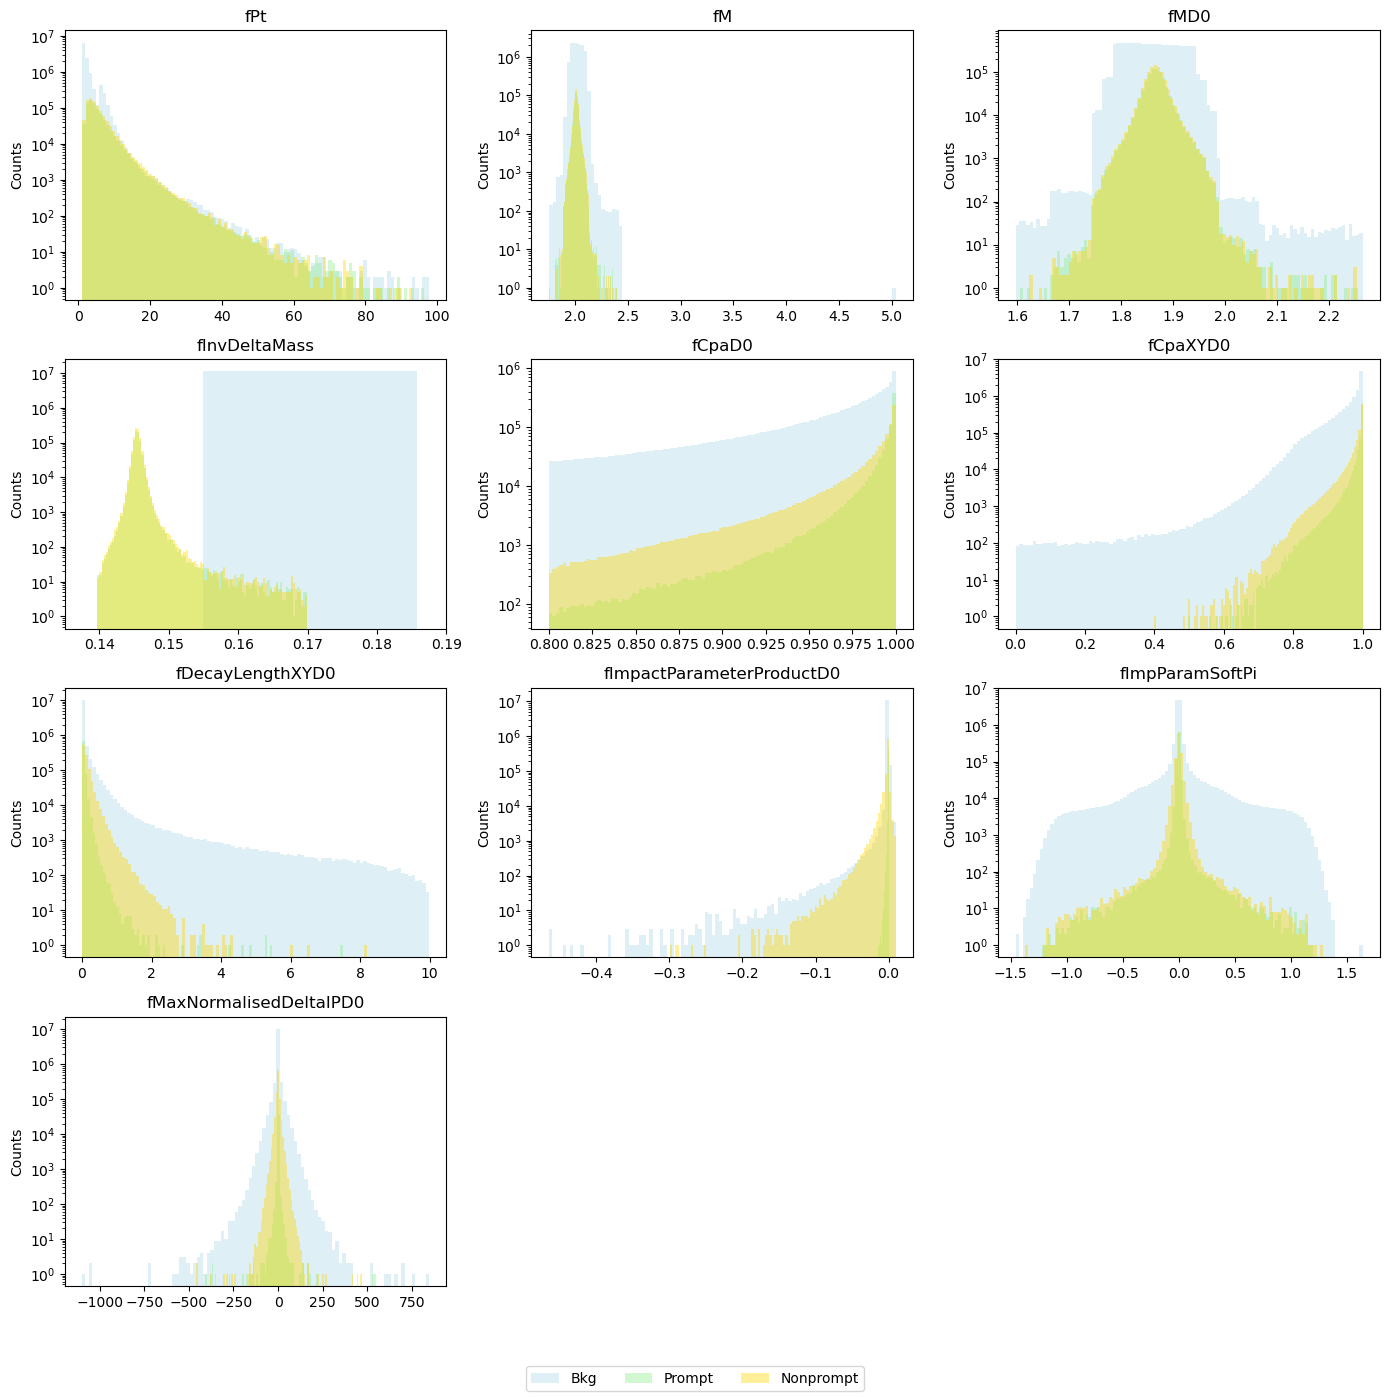

In [14]:
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

files = {
    "Bkg": "/Users/ananyay/Downloads/Bkg_DstarToD0Pi.root",
    "Prompt": "/Users/ananyay/Downloads/Prompt_DstarToD0Pi.root",
    "Nonprompt": "/Users/ananyay/Downloads/Nonprompt_DstarToD0Pi.root"
}

variables = [
    "fPt",
    "fM",
    "fMD0",
    "fInvDeltaMass",
    "fCpaD0",
    "fCpaXYD0",
    "fDecayLengthXYD0",
    "fImpactParameterProductD0",
    "fImpParamSoftPi",
    "fMaxNormalisedDeltaIPD0"
]

dfs = {}
for label, path in files.items():
    f = uproot.open(path)
    t = f["treeMLDstar"]
    dfs[label] = t.arrays(variables, library="pd")

fig, axes = plt.subplots(4,3, figsize=(14,14))
axes = axes.flatten()

colors = {"Bkg":"lightblue", "Prompt":"lightgreen", "Nonprompt":"gold"}

for i, var in enumerate(variables):
    ax = axes[i]
    for lab, df in dfs.items():
        ax.hist(df[var], bins=100, histtype="stepfilled", alpha=0.4,
                label=lab, color=colors[lab])
    if var == "fInvDeltaMass":
        ax.set_xlim(0.135, 0.19)
    ax.set_yscale("log")         
    ax.set_title(var)
    ax.set_ylabel("Counts")
    ax.set_xlabel("")

fig.delaxes(axes[-1])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3)

if len(axes) > len(variables):
    for j in range(len(variables), len(axes)):
        try:
            fig.delaxes(axes[j])
        except KeyError:
            pass

print("Plots of keys combined (same as ppt)")
plt.tight_layout(rect=[0,0.05,1,1])
plt.show()

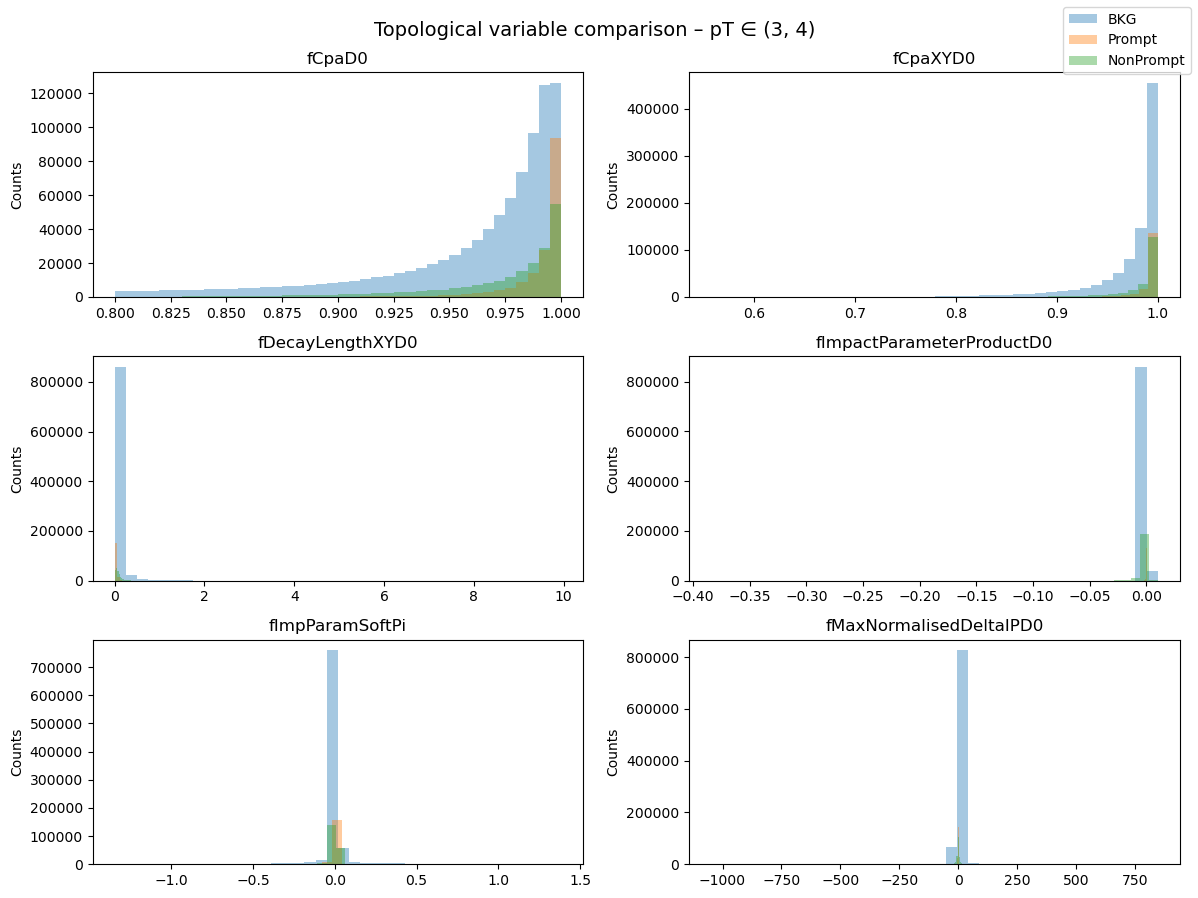

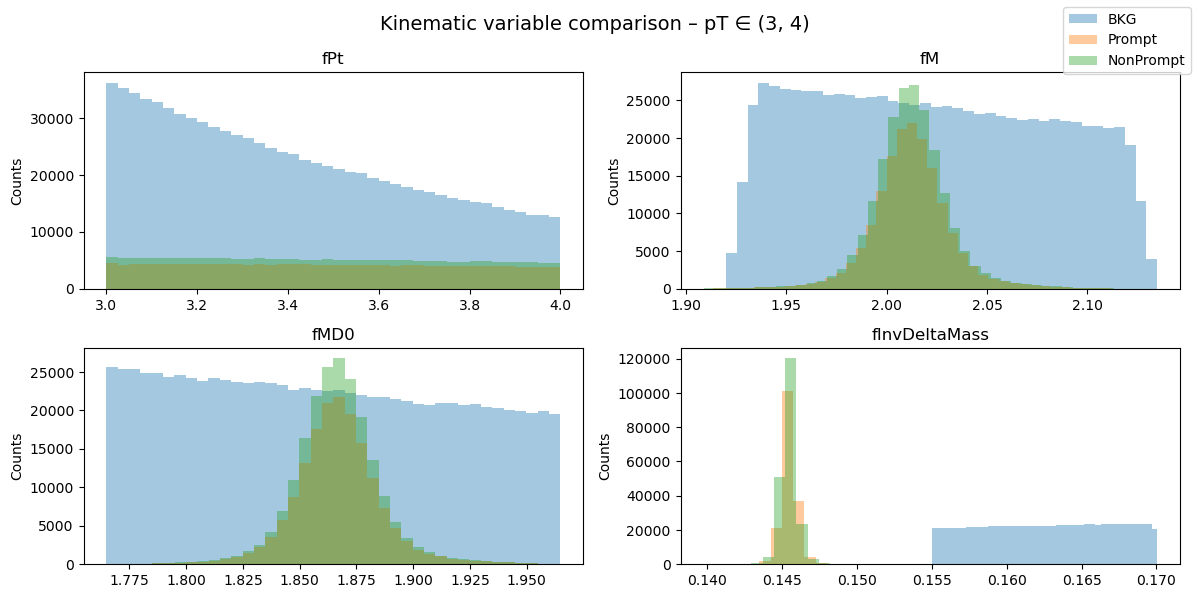

Hyper Parameters are: 
Max depth:  4
Learning rate:  0.1
N Estimators:  300
Subsample:  0.8
Colsample Bytree:  0.8


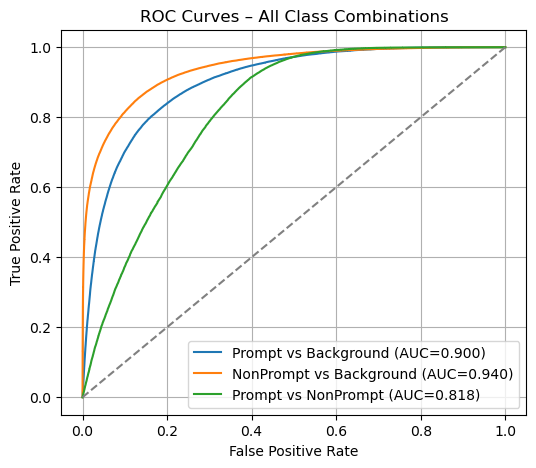

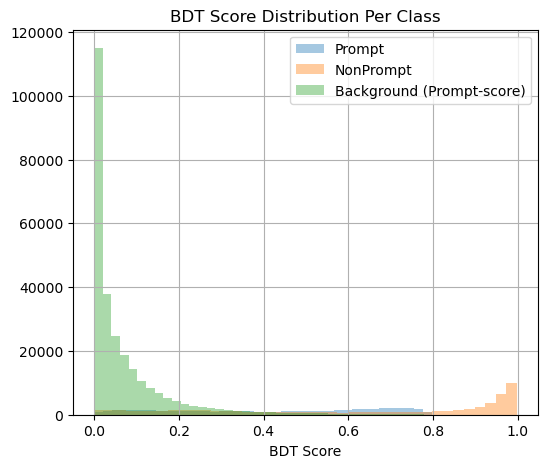

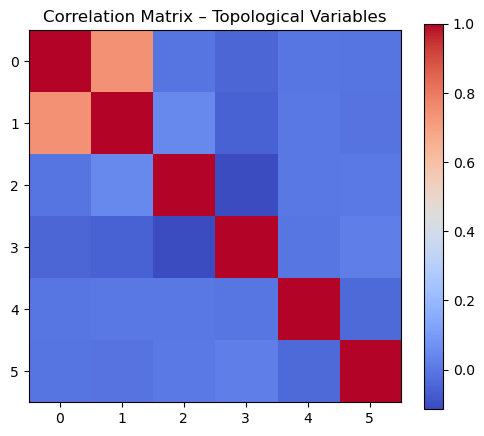

In [34]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

TOP_VARIABLES = [
    "fCpaD0",
    "fCpaXYD0",
    "fDecayLengthXYD0",
    "fImpactParameterProductD0",
    "fImpParamSoftPi",
    "fMaxNormalisedDeltaIPD0"
]

KIN_VARIABLES = ["fPt", "fM", "fMD0", "fInvDeltaMass"]

PT_RANGE = (3, 4)   # I chose (3,4) as my pt range
TEST_SIZE = 0.30

FILE_PROMPT = "/Users/ananyay/Downloads/Prompt_DstarToD0Pi.root"
FILE_NONPROMPT = "/Users/ananyay/Downloads/Nonprompt_DstarToD0Pi.root"
FILE_BKG = "/Users/ananyay/Downloads/Bkg_DstarToD0Pi.root"

def load_root(filepath):
    f = uproot.open(filepath)
    tree = f["treeMLDstar"]
    data = tree.arrays(TOP_VARIABLES + KIN_VARIABLES, library="pd")
    return data

df_prompt = load_root(FILE_PROMPT)
df_nonprompt = load_root(FILE_NONPROMPT)
df_bkg = load_root(FILE_BKG)

df_prompt["class"] = 1      
df_nonprompt["class"] = 2   
df_bkg["class"] = 0         

# filtering
low, high = PT_RANGE
df_prompt_bin = df_prompt[(df_prompt["fPt"] >= low) & (df_prompt["fPt"] < high)]
df_nonprompt_bin = df_nonprompt[(df_nonprompt["fPt"] >= low) & (df_nonprompt["fPt"] < high)]
df_bkg_bin = df_bkg[(df_bkg["fPt"] >= low) & (df_bkg["fPt"] < high)]

df_all = pd.concat([df_prompt_bin, df_nonprompt_bin, df_bkg_bin], ignore_index=True)

def plot_vars(df_sig, df_np, df_bg, variables, name="topological"):
    n = len(variables)
    rows = (n + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 3))
    axes = axes.flatten()

    for i, var in enumerate(variables):
        ax = axes[i]
        bins = 40
        ax.hist(df_bg[var], bins=bins, alpha=0.4, label="BKG")
        ax.hist(df_sig[var], bins=bins, alpha=0.4, label="Prompt")
        ax.hist(df_np[var], bins=bins, alpha=0.4, label="NonPrompt")
        ax.set_title(var)
        ax.set_ylabel("Counts")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
    fig.suptitle(f"{name} variable comparison – pT ∈ {PT_RANGE}", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_vars(df_prompt_bin, df_nonprompt_bin, df_bkg_bin, TOP_VARIABLES, "Topological")
plot_vars(df_prompt_bin, df_nonprompt_bin, df_bkg_bin, KIN_VARIABLES, "Kinematic")

X = df_all[TOP_VARIABLES]      # using topological variables only
y = df_all["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

# change hyperparameters accordingly
md = 4
lr = 0.1
ne = 300
sb = 0.8
cb = 0.8

model = XGBClassifier(
    max_depth=md,
    learning_rate=lr,
    n_estimators=ne,
    subsample=sb,
    colsample_bytree=cb,
    eval_metric="logloss"
)

model.fit(X_train, y_train)
print("Hyper Parameters are: ")
print("Max depth: ",md)
print("Learning rate: ",lr)
print("N Estimators: ",ne)
print("Subsample: ",sb)
print("Colsample Bytree: ",cb)

pred_prob = model.predict_proba(X_test)

mask_prompt = y_test == 1
mask_bkg = y_test == 0
y_bin = y_test.map({1:1, 0:0, 2:0})

fpr, tpr, _ = roc_curve(y_bin, pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))

y_bin_pb = y_test.map({1:1, 0:0, 2:0})
fpr, tpr, _ = roc_curve(y_bin_pb, pred_prob[:,1])
auc_pb = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Prompt vs Background (AUC={auc_pb:.3f})")

y_bin_nb = y_test.map({2:1, 0:0, 1:0})
fpr, tpr, _ = roc_curve(y_bin_nb, pred_prob[:,2])
auc_nb = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"NonPrompt vs Background (AUC={auc_nb:.3f})")

mask = y_test != 0
y_test_sig = y_test[mask]
pred_sig  = pred_prob[:,1:3][mask]

y_bin_pn = y_test_sig.map({1:1, 2:0})
fpr, tpr, _ = roc_curve(y_bin_pn, pred_sig[:,0]) 
auc_pn = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Prompt vs NonPrompt (AUC={auc_pn:.3f})")

plt.plot([0,1],[0,1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – All Class Combinations")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6,5))
plt.hist(pred_prob[:,1][y_test==1], bins=40, alpha=0.4, label="Prompt")
plt.hist(pred_prob[:,2][y_test==2], bins=40, alpha=0.4, label="NonPrompt")
plt.hist(pred_prob[:,1][y_test==0], bins=40, alpha=0.4, label="Background (Prompt-score)")
plt.xlabel("BDT Score")
plt.title("BDT Score Distribution Per Class")
plt.legend()
plt.grid()
plt.show()

corr = X_train.corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap="coolwarm")
plt.title("Correlation Matrix – Topological Variables")
plt.colorbar()
plt.show()

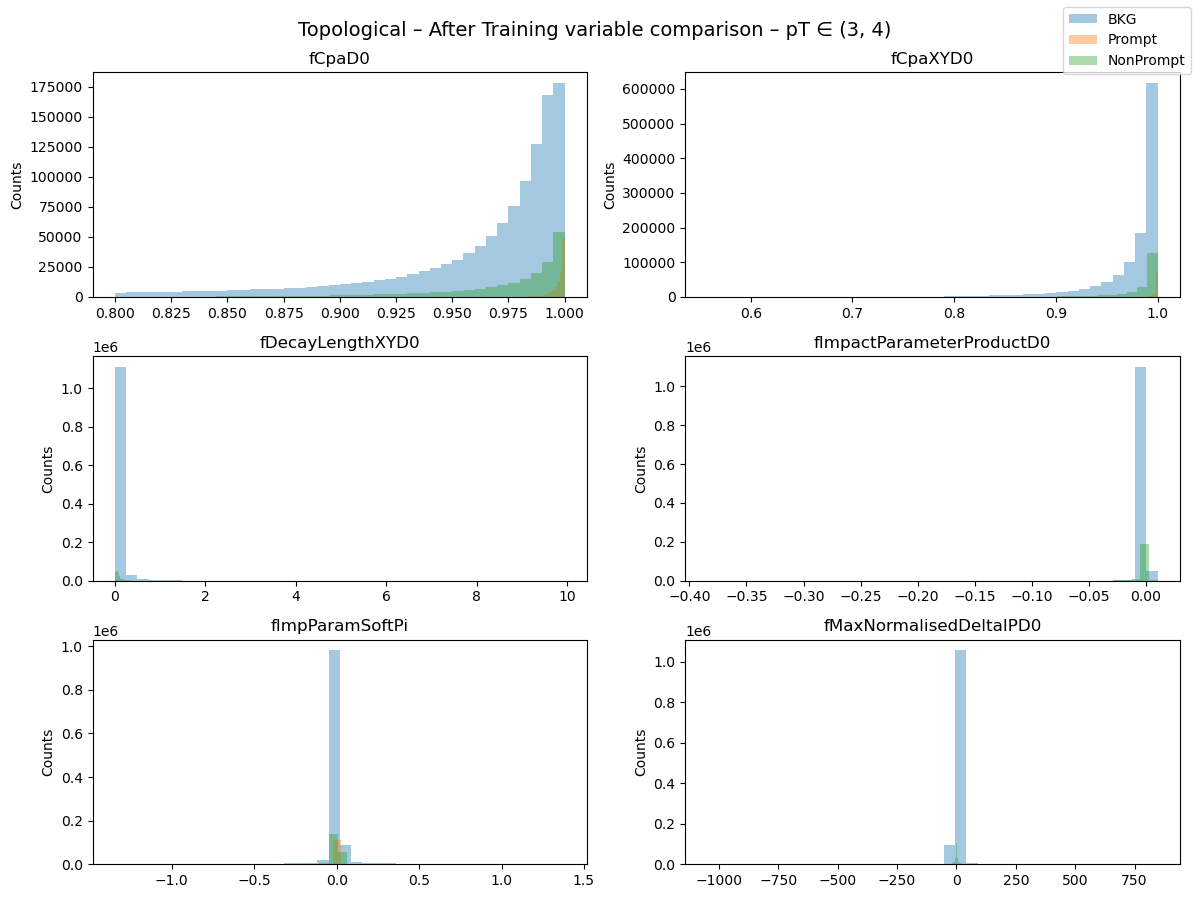

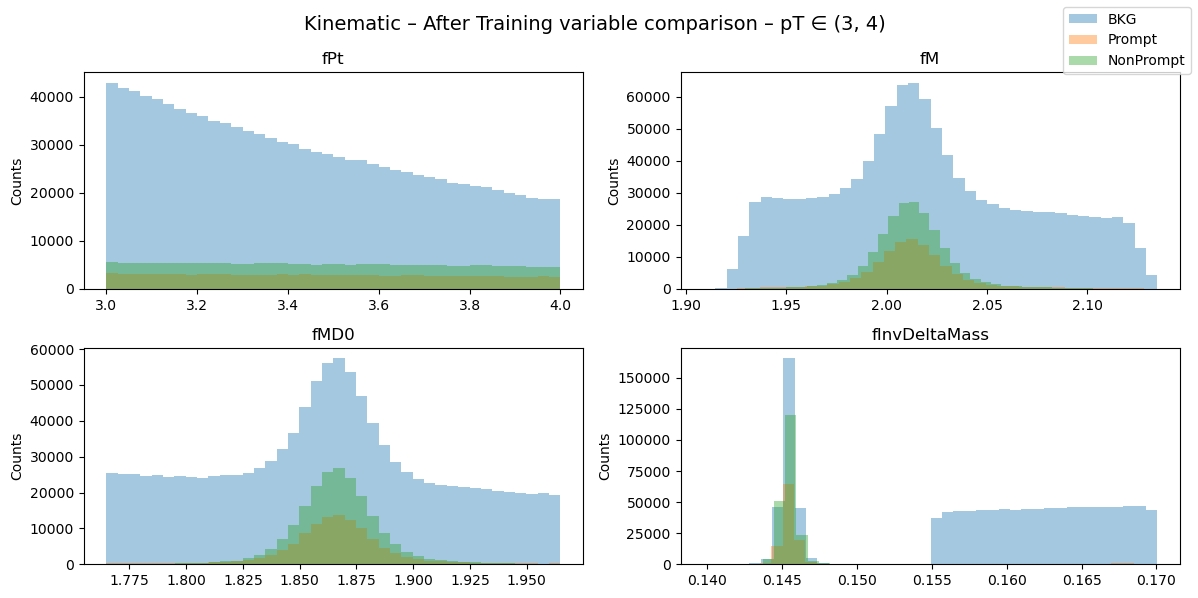

In [35]:
df_all["bdt_score"] = model.predict_proba(df_all[TOP_VARIABLES])[:, 1]

score_cut = 0.5   # threshold

df_pred_sig  = df_all[df_all["bdt_score"] > score_cut]          
df_pred_bkg  = df_all[df_all["bdt_score"] <= score_cut]         
df_pred_np   = df_all[df_all["class"] == 2]                     

plot_vars(df_pred_sig, df_pred_np, df_pred_bkg, TOP_VARIABLES, name="Topological – After Training")
plot_vars(df_pred_sig, df_pred_np, df_pred_bkg, KIN_VARIABLES, name="Kinematic – After Training")